# Exercise 3: Estimating an $RC$ model from measurement data

## Overview

In this exercise, you will estimate parameters of a simple grey-box thermal model (a $1R–1C$ reduced-order model) using measurement data from an occupied, semi-detached house in the UK [1], which was retrofitted in Spring/Summer 2016 and occupied in September 2016. The data set is publicly available [here](https://discovery.ucl.ac.uk/id/eprint/10087216/) and comprises two 5-day periods of measurements at a 10-minute resolution.

By the end of this exercise, you should be able to:
- Prepare and sanity-check time-series measurement data.
- Formulate a $1R–1C$ model and estimate its parameter by solving a constrained least squares problem.
- Validate the model performance on a hold-out set.

Note that the $1R–1C$ reduced-order model is a simplified representation of the building envelope. Moreover, we will use available measurements as *proxies* for sensible heat gains. As a result, some fitted parameters should be interpreted as effective/lumped values rather than exact physical properties.

[1] Hollick, F; Wingfield, J; (2018) Two periods of in-situ measurements from an occupied, semi-detached house in the UK [Dataset]. 10.14324/000.ds.10087216.

## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy.optimize import lsq_linear

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (10, 4)

## Load and inspect the 2016 data

We first load and visualize the data. First, set up the ```data_path``` variable to the correct file location and load the data set. The data set spans two 5-day periods. The data from the first period (November 2016) is considered first.

In [2]:
# ---- Path configuration (edit if needed) ----

# Load measurement data
data_path = 'C:\\Users\\ucbva19\\Git projects\\BENV0092\\data raw'
raw_data = pd.read_csv(f'{data_path}\\10mins_solpap_2016.csv', index_col = 0)
raw_data.index = pd.to_datetime(raw_data.index, format="%d/%m/%Y %H:%M")

display(raw_data.head(3))
print('Missing (%) by column:')
print((100 * raw_data.isna().mean()).sort_values(ascending=False).head(10))

,T_Bath (degC),T_Bed1 (degC),T_Bed2 (degC),El_use (W),T_External (degC),Gas (W),T_Kitchen (degC),T_Living (degC),Solar (W/m2),T_Store (degC),T_Thermostat (degC),T_Average (degC),P_tot (W)
Date and time,,,,,,,,,,,,,
2016-11-11 00:00:00,19.9,17.0,17.2,528,5.0,6817.60,19.3,18.5,0.0,13.1,16.0,17.457,7345.60
2016-11-11 00:10:00,20.0,17.1,17.1,288,5.2,4090.56,19.2,18.5,0.0,13.2,16.1,17.484,4378.56
2016-11-11 00:20:00,20.0,17.1,17.2,354,5.2,681.76,19.2,18.5,0.0,13.2,16.0,17.480,1035.76


Missing (%) by column:
T_External (degC)      2.638889
T_Thermostat (degC)    0.138889
T_Average (degC)       0.138889
T_Bath (degC)          0.000000
T_Bed1 (degC)          0.000000
T_Bed2 (degC)          0.000000
El_use (W)             0.000000
Gas (W)                0.000000
T_Kitchen (degC)       0.000000
T_Living (degC)        0.000000
dtype: float64


### Quick visual sanity check

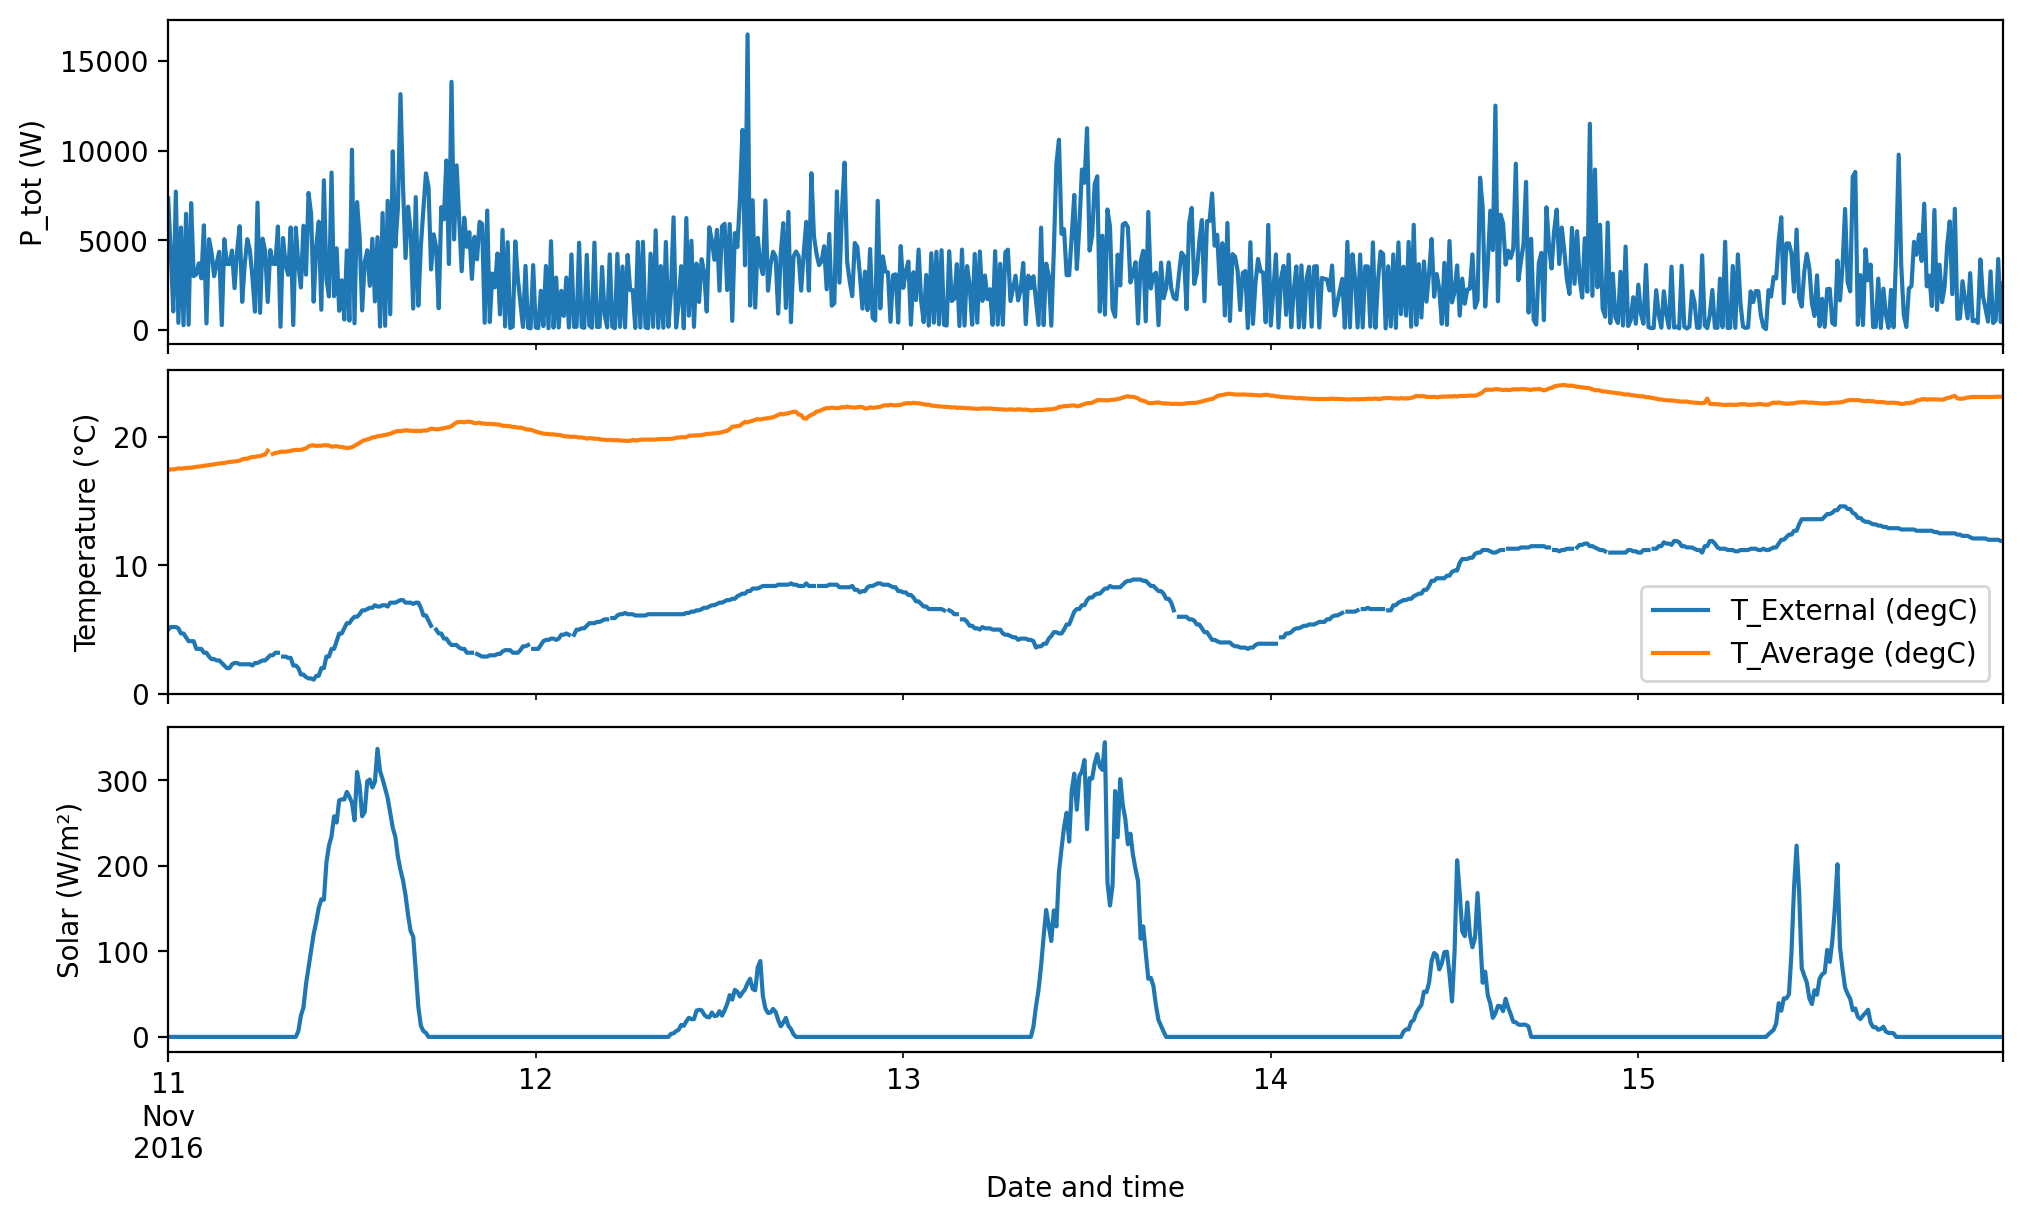

In [3]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 6))

raw_data['P_tot (W)'].plot(ax=ax[0])
ax[0].set_ylabel('P_tot (W)')

raw_data[['T_External (degC)', 'T_Average (degC)']].plot(ax=ax[1])
ax[1].set_ylabel('Temperature (°C)')

raw_data['Solar (W/m2)'].plot(ax=ax[2])
ax[2].set_ylabel('Solar (W/m²)')

plt.show()


## Handle missing data

Some variables contain missing data. A good practice is to visually examine the missing data and then pick an appropriate imputation method. Given the nature of the data (time series, 10-minute resolution), linear interpolation seems appropriate. 

**Question**:
- The most common imputation method is to replace missing data with the mean value. Implement this approach and provide a visual comparison against linear interpolation. Which approach do you think is better and why?

In [4]:
# Fill missing data with linear interpolation
data = raw_data.copy().interpolate('linear')
assert(data.isna().all().sum() == 0)

############ Insert your code here
# Apply mean imputation and compare it with linear interpolation


## Model formulation: $1R–1C$ (single-zone)

We model the indoor temperature (single zone) with a $1R–1C$ thermal network.

- $R_{\mathrm{th}}$ : thermal resistance (°C/kW)
- $C_{\mathrm{th}}$ : thermal capacitance (kWh/°C)
- $\tau = R_{\mathrm{th}} C_{\mathrm{th}}$ : time constant (h)

### Continuous-time energy balance

The continuous-time energy balance is given by

<center>$ C_{\mathrm{th}} \frac{dT}{dt} = \frac{T_\mathrm{ext} - T}{R_{\mathrm{th}}} + H_\mathrm{heat} + g  S$,</center>

where:
- $T$ is indoor temperature (°C), $T_{\mathrm{ext}}$ is outdoor temperature (°C)
- $H_{\mathrm{heat}}$ is a proxy for net heat injection (kW). Here we use total power as a proxy.
- $S$ is a **solar proxy** (W/m²). The unknown coefficient $g$ lumps window area, transmittance, shading, etc.

Rearrange:
<center>$ \frac{dT}{dt} =
\frac{1}{\tau}(T_\mathrm{ext} - T)
+ \frac{1}{C_{\mathrm{th}}}H_{\mathrm{heat}}  + \frac{g}{C_{\mathrm{th}}}S $.</center>

### Discretisation (forward Euler)
With time step $\Delta t$ (hours):

<center>
$
    \Delta T_k := 
T_{k+1}-T_{k}
= \alpha_1(T_{\mathrm{ext},k} - T_{k})
+ \alpha_2 H_{\mathrm{heat},k} + \alpha_3 S_k,
$    
</center>

where:
- $\alpha_1 = \Delta t/\tau$,
- $\alpha_2 = \Delta t/ C_{\mathrm{th}}$,
- $\alpha_3 = \Delta t \cdot g/C_{\mathrm{th}}$.

This is a linear regression in $(\alpha_1,\alpha_2,\alpha_3)$, where the temperature difference between steps $k+1$ and $k$ is the target (response) variable.


## Build the regression dataset


We use:
- $T$ = `T_Average (degC)`
- $T_{\mathrm{ext}}$ = `T_External (degC)`
- $H_{\mathrm{heat}}$ proxy = `P_tot (W)` converted to **kW**
- solar proxy = `Solar (W/m2)` (we assume that the coefficient absorbs scaling)

Then:
- response: `dT = T_k+1 - T_k`
- features: `T_diff = T_ext - T_k`, `P_tot_kW`, `Solar_proxy`


In [5]:
# Discretisation step: 10 minutes = 1/6 hour
DT_H = 1/6

# Rename signals for clarity
T = data['T_Average (degC)']
T_ext = data['T_External (degC)']

# Proxies
P_tot_kW = data['P_tot (W)'] / 1000.0
Solar_proxy = data['Solar (W/m2)']

# Build one-step-ahead response
T_lead = T.shift(-1)
dT = T_lead - T

# Feature: driving temperature difference
T_diff = T_ext - T

# Assemble dataset and drop the final NaN (from shift)
df = pd.DataFrame({
    'dT': dT, 'T_diff': T_diff,
    'P_tot_kW': P_tot_kW, 'Solar_proxy': Solar_proxy,'T': T,'T_ext': T_ext,})

df = df.dropna()
display(df.head(3))

,dT,T_diff,P_tot_kW,Solar_proxy,T,T_ext
Date and time,,,,,,
2016-11-11 00:00:00,0.027,-12.457,7.34560,0.0,17.457,5.0
2016-11-11 00:10:00,-0.004,-12.284,4.37856,0.0,17.484,5.2
2016-11-11 00:20:00,0.033,-12.280,1.03576,0.0,17.480,5.2


## Train / test chronological split

Because this is time-series data, we split chronologically (no shuffling).


In [6]:
n = len(df)
split = int(0.7 * n)

X_cols = ['T_diff', 'P_tot_kW', 'Solar_proxy']

train_df = df.iloc[:split].copy()
test_df = df.iloc[split:].copy()

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

print('Train period:', train_df.index.min(), '→', train_df.index.max())
print('Test period :', test_df.index.min(), '→', test_df.index.max())


Train period: 2016-11-11 00:00:00 → 2016-11-14 11:40:00
Test period : 2016-11-14 11:50:00 → 2016-11-15 23:40:00


## Fit the $RC$ model (constrained least squares)

We estimate $(\alpha_1, \alpha_2, \alpha_3)$ by solving a least squares problem on the training set. We impose the following constraints to ensure results are physically meaningful:
- $\alpha_1 \ge 0$ : higher $|T_{ext}-T|$ should increase $|\Delta T|$ (absolute values)
- $\alpha_2 \ge 0$ : higher heating power proxy should increase $\Delta T$
- $\alpha_3 \ge 0$ : higher solar proxy should increase $\Delta T$

Then recover:
- $\tau = \Delta t/\alpha_1$
- $C_{\mathrm{th}} = \Delta t/\alpha_2$
- $R_{\mathrm{th}} = \tau/C_{\mathrm{th}}$
- $g = \alpha_3/\alpha_2$ (effective solar gain factor)


In [7]:
################################

# Insert your code here
# Estimate coefficients alpha_1,2,3 by solving a constrained least squares problem
# You can use lsq_linear or cvxpy

# Recover RC parameters (estimate and print tau, C_th, R_th, g_eff)
tau = None
C_th = None
R_th = None
g_eff = None

print('Estimated coefficients (alpha):')

print('Recovered RC parameters (effective):')


Estimated coefficients (alpha):
Recovered RC parameters (effective):


## Evaluate on hold-out test set

We compute one-step-ahead predictions of $\Delta T$ and reconstruct $T_{k+1}$:
$\hat{T}_{k+1} = T_k + \widehat{\Delta T}_k$

We report RMSE on:
- $\Delta T$ (modelled directly)
- $T$ one-step-ahead (often easier to interpret)


In [8]:
########## Insert your code

# Estimate RMSE in training and test set

print('RMSE (one-step-ahead)')
print(f'  Train: dT RMSE = {None} °C')
print(f'  Test : dT RMSE = {None} °C')


RMSE (one-step-ahead)
  Train: dT RMSE = None °C
  Test : dT RMSE = None °C


### Visualise hold-out performance (one-step-ahead)

Create a plot of one-step ahead temperature forecasts.

## Benchmark: unconstrained linear regression

To illustrate why constraints matter, we next fit an *unconstrained* linear regression on the same $\Delta T$ formulation. 

In practice, the unconstrained fit can yield negative parameters (non-physical).

In [9]:
################ Insert code here

# Train a linear regression model using sklearn; estimate and print R,C,tau, g; estimate train/test RMSE

## Multi-step ahead forecasting (or rollout simulation)

Instead of one-step-ahead prediction, we now simulate forward on the test set using the model's own predicted temperature as input. In the time series forecasting literature, this technique is referred to as "recursive" forecasting [2].

2. Taieb, S.B., Bontempi, G., Atiya, A.F. and Sorjamaa, A., 2012. A review and comparison of strategies for multi-step ahead time series forecasting based on the NN5 forecasting competition. Expert systems with applications, 39(8), pp.7067-7083.


In [10]:
################### Insert your code here

# Steps to implement multi-step ahead forecasting using the recursive method
# 1. Set k = 0
# 2. Predict dT_k = T_k+1 - T_k, find one-step ahead prediction T_{k+1}_hat
# 3. Set T_{k+1}_hat as the true value for time step k+1
# 4. Update index to k = k+1 and go back to step 2


## Optional extensions

1. **Model order**: compare $1R1C$ vs $2R2C$.
2. **Other models**: compare against statistical (e.g., ARIMA) or machine learning models (e.g., neural nets).
3. **Residual diagnostics**: check autocorrelation of residuals to identify missing dynamics.
